In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# Constants
N_CLASSES = 4
CLASS_NAMES = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
base_dir = "Combined_MRI_Dataset"
output_dir = os.path.join(base_dir, "model_output")

class VentricleDataset(Dataset):
    def __init__(self, base_dir, split='test'):
        self.data_dir = os.path.join(base_dir, "normalized", split)
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = os.path.join(self.data_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory {class_dir} not found.")
                continue
                
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith('mask.png'):
                    self.images.append(os.path.join(class_dir, img_file))
                    self.labels.append(class_idx)
        
        print(f"Loaded {len(self.images)} images for {split} split")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        return TF.to_tensor(img), torch.tensor(self.labels[idx], dtype=torch.long)



In [3]:
class VentricleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Two convolutional blocks
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        # Flattened size after 2 pooling layers (4x reduction)
        self.fc_input_size = 128 * (IMG_SIZE[0]//4) * (IMG_SIZE[1]//4)
        
        # Classifier
        self.fc1 = nn.Linear(131072, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(128, N_CLASSES)
    
    def forward(self, x):
        x = self.batchnorm1(self.pool1(F.relu(self.conv1(x))))
        x = self.batchnorm2(self.pool2(F.relu(self.conv2(x))))
    
        x = x.view(x.size(0), -1)  # Flatten    
    
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        return self.out(x)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    
    return accuracy, cm, report

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

def ventricle_gradcam(model, img_tensor, target_class=None):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize containers for feature maps and gradients
    activations = None
    gradients = None
    
    # Define hooks to capture activations and gradients
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
    
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]
    
    # Register hooks on the second convolutional layer
    forward_handle = model.conv2.register_forward_hook(forward_hook)
    backward_handle = model.conv2.register_full_backward_hook(backward_hook)
    
    # Forward pass
    output = model(img_tensor)
    
    # Determine target class
    if target_class is None:
        target_class = torch.argmax(output, dim=1).item()
    
    # Zero gradients
    model.zero_grad()
    
    # Target for backpropagation
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    
    # Backward pass
    output.backward(gradient=one_hot, retain_graph=True)
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    # Average gradients across spatial dimensions
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    
    # Generate weighted activation map
    cam = torch.sum(weights * activations, dim=1, keepdim=True)
    
    # Apply ReLU to highlight positive influences only
    cam = F.relu(cam)
    
    # Normalize CAM
    if torch.max(cam) > 0:
        cam = cam / torch.max(cam)
    
    # Resize CAM to match input image size
    cam = F.interpolate(cam, size=img_tensor.shape[2:], mode='bilinear', align_corners=False)
    
    # Convert to numpy arrays for visualization
    cam_np = cam.detach().cpu().squeeze().numpy()
    
    # Get original image
    img_np = img_tensor.detach().cpu().squeeze().numpy()
    
    # Create heatmap using a colormap appropriate for medical imaging
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Create colorful visualization for the binary mask
    # For binary images, we need to properly scale the overlay
    img_3channel = np.stack([img_np, img_np, img_np], axis=2)
    
    # Create the overlay with appropriate transparency for binary masks
    # Use higher alpha for binary masks to make heatmap more visible
    alpha = 0.7
    overlay = (1-alpha) * img_3channel + alpha * heatmap / 255.0
    
    # Return original image, raw CAM, and the overlay
    return img_np, cam_np, overlay, target_class

# Function to visualize the results
def visualize_ventricle_gradcam(model, image_path, class_names, transform):
    # Load image
    image = Image.open(image_path)
    
    # Apply transformations
    input_tensor = transform(image).unsqueeze(0)
    
    # Generate Grad-CAM
    original, cam, overlay, pred_class = ventricle_gradcam(model, input_tensor)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original mask
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Ventricle Mask')
    axes[0].axis('off')
    
    # Raw CAM
    im1 = axes[1].imshow(cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (Class: {class_names[pred_class]})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class

In [5]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.close()

def load_model(model_path):
    model = VentricleCNN()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    print("Model loaded successfully")
    return model

def main():
    os.makedirs(output_dir, exist_ok=True)
    
    print("Loading data...")
    test_set = VentricleDataset(base_dir, 'test')
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    print("Loading model...")
    model_path = os.path.join(output_dir, "best_model.pt")
    model = load_model(model_path)
    
    print("Evaluating model...")
    accuracy, cm, report = evaluate_model(model, test_loader)
    
    print("Generating visualizations...")
    plot_confusion_matrix(cm)
    
    print("Saved all results to:", output_dir)

if __name__ == "__main__":
    main()

Loading data...
Loaded 3584 images for test split
Loading model...


/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_1367/25181947.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, ma

Model loaded successfully
Evaluating model...


Evaluating: 100%|█████████████████████████████| 112/112 [00:16<00:00,  6.99it/s]



Test Accuracy: 0.9305

Confusion Matrix:
[[ 687    0   14   26]
 [   0  527    0    0]
 [  10    0 1204   66]
 [  22    0  111  917]]

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9555    0.9450    0.9502       727
 Moderate_Demented     1.0000    1.0000    1.0000       527
      Non_Demented     0.9059    0.9406    0.9230      1280
Very_Mild_Demented     0.9088    0.8733    0.8907      1050

          accuracy                         0.9305      3584
         macro avg     0.9426    0.9397    0.9410      3584
      weighted avg     0.9307    0.9305    0.9304      3584

Generating visualizations...
Saved all results to: Combined_MRI_Dataset/model_output


In [6]:
def analyze_ventricle_with_gradcam(model_path, image_path, class_names):
    # Set up model
    model = VentricleCNN()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    # Define appropriate transforms for binary ventricle masks
    transform = transforms.Compose([
        # Resize to match your model's expected input size
        # Modify this based on what your model expects
        transforms.Resize((128, 128)),  # Adjust to your IMG_SIZE
        transforms.ToTensor(),
        # Single channel normalization for binary images
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Visualize
    predicted_class = visualize_ventricle_gradcam(model, image_path, class_names, transform)
    
    print(f"Predicted class: {class_names[predicted_class]}")
    return predicted_class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30000001192092896..1.000000011920929].


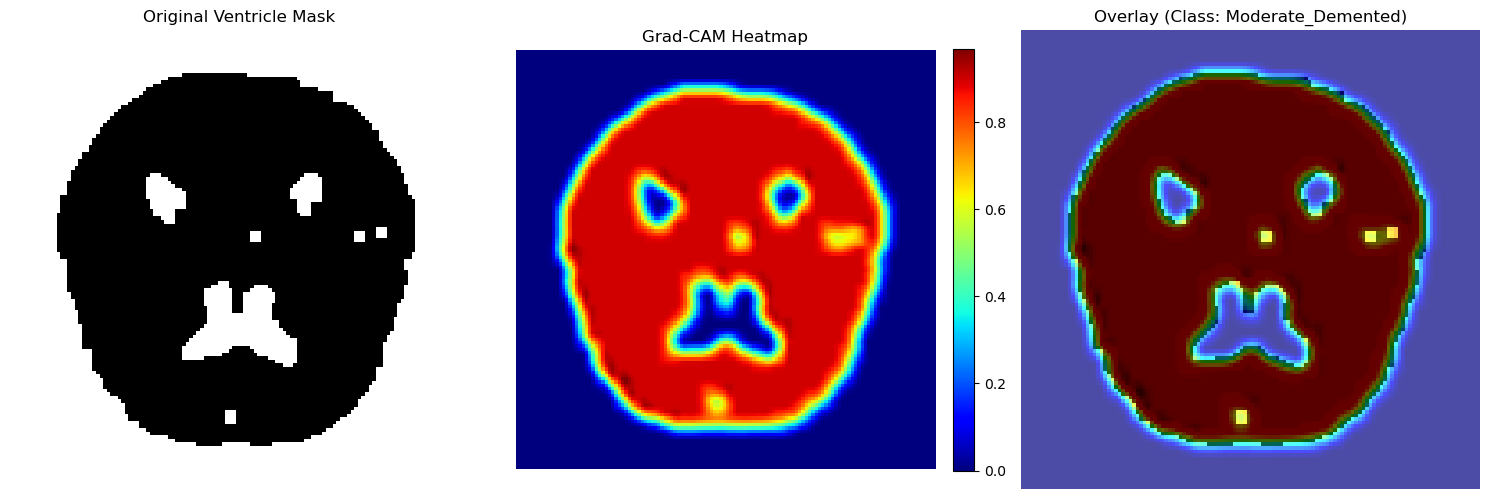

Predicted class: Moderate_Demented


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30000001192092896..1.000000011920929].


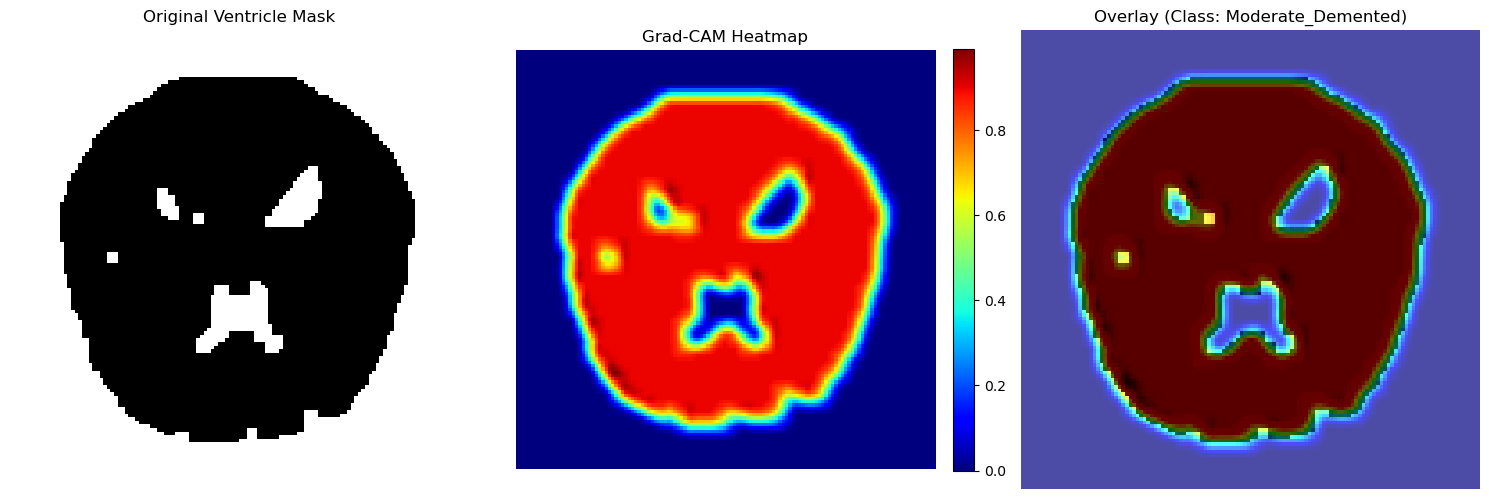

Predicted class: Moderate_Demented


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30000001192092896..1.000000011920929].


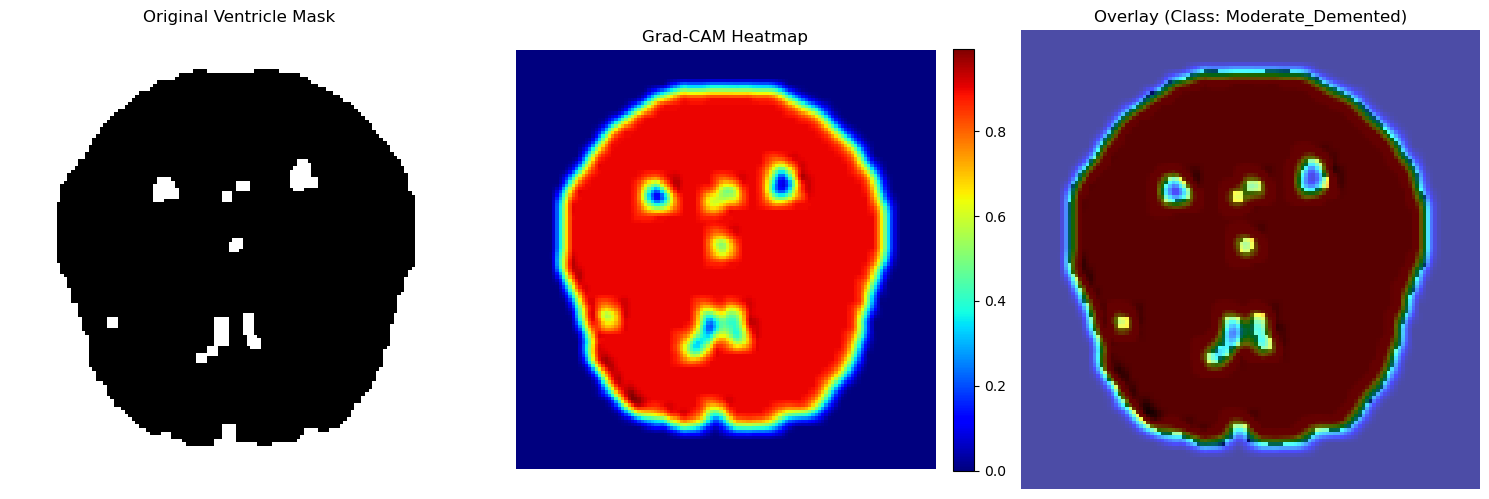

Predicted class: Moderate_Demented


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30000001192092896..1.000000011920929].


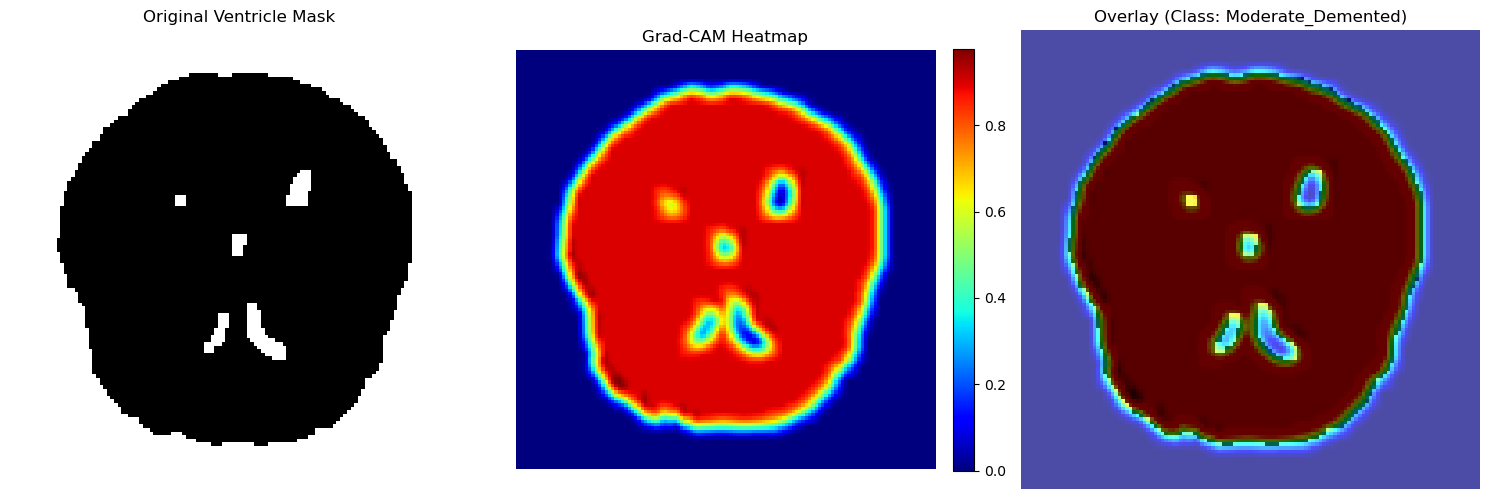

Predicted class: Moderate_Demented


In [7]:
from torchvision import transforms

# Define your class names - modify based on your actual classes
CLASS_NAMES = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

# Path to your model weights and test image
model_path = './Combined_MRI_Dataset/model_output/best_model.pt'
image_path_Moderate = './Combined_MRI_Dataset/normalized/test/Moderate_Demented/folder_Moderate_Demented_0007_mask.png'
image_path_Mild='./Combined_MRI_Dataset/normalized/test/Mild_Demented/folder_Mild_Demented_0006_mask.png'
image_path_Non='./Combined_MRI_Dataset/normalized/test/Non_Demented/folder_Non_Demented_0005_mask.png'
image_path_Very='./Combined_MRI_Dataset/normalized/test/Very_Mild_Demented/folder_Very_Mild_Demented_0007_mask.png'

# Run analysis
predicted_class = analyze_ventricle_with_gradcam(model_path, image_path_Moderate, CLASS_NAMES)
predicted_class_2 = analyze_ventricle_with_gradcam(model_path, image_path_Mild, CLASS_NAMES)
predicted_class_3 = analyze_ventricle_with_gradcam(model_path, image_path_Non, CLASS_NAMES)
predicted_class_4 = analyze_ventricle_with_gradcam(model_path, image_path_Very, CLASS_NAMES)


